# In this notebook, I implemented a neural network from scratch, which tells us whether two given questions are similar or not 

## We will use the Quora duplicate questions dataset which is available here, unzip it and you are good to go 'quora_duplicate_questions.tsv.zip'.

# $\color{blue}{\text{Summary of main results}}$

## - My research indicates that using some higher order correlators could enhance the accuracy of the neural networks in question. The original Kaggle award winning solution used an ensemble model with Siamese LSTM networks (see the figure below for a typical neural net used by them), with an accuracy of 88.75 %. Using some higher order correlators in each of the neural nets involved in their solution, could further increase their accuracy. The current state of the art according to the GLUE benchmark is 90.6 % accuracy by team Google (methods based on BERT). Using these higher order correlators on sentence embeddings obtained using BERT could further increase this accuracy. 

<img src="AML_poster_outline.jpg" alt="Drawing" style="width: 400px;"/>

## - Say we want to figure out whether question 1 and question 2 are similar or not. Let $q_1$ and $q_2$ be the LSTM outputs for the question 1 and question 2. In the original Kaggle award winning model, these outputs were combined using functions like $\frac{q_1 + q_2}{2}$, $|q_1 - q_2|$, $\max(q_1, q_2)$ and $q_1*q_2$. These functions can be thought of as correlators, as they effectively measure some abstract similarity feature between the two questions. 

## - I noticed that  $q_1*q_2$ is of second order $\mathcal{O}(q^2)$. So, I coded in the other second order correlators, for example, $|q_1^2 - q_2^2|$, $\max{(q_1^2, q_2^2)}$ and $\frac{q_1^2 + q_2^2}{2}$. These other second order correlators do indeed increase the performance of the network.

## - Then I proceeded to higher order correlators. The table below presents the accuracy of a single neural using such correlators. I found that not all correlators are as high performing. This can be understood by considering the symmetry properties of the various correlators. Different correlators transform differently under various symmetry operations, for example rotation and translation in $q-space$.  

## - The best way to figure out which correlators are better is to simply try them out! Check the table below for comparison. The size of the hidden state is fixed to 1024 and the size of the embedding matrix is fixed to 512. I noticed that one could reach an accuracy of 83.6 % for a single neural net by concatenating the high performing correlators (this number would probably go up if we increase the size of hidden state and train for more epochs).


|Correlators|Accuracy (%)|
|---|---|
|$\max{(q_1, q_2)}$|82.82|
|$\frac{q_1+q_2}{2}$|79.09|
|$|q_1 - q_2|$|82.98|
|$q_1\ast q_2$|82.25|
|$\max{(q_1^2, q_2^2)}$|80.59|
|$\frac{q_1^2+q_2^2}{2}$|79.10|
|$|q_1^2 - q_2^2|$|82.95|
|$\frac{q_1^3+q_2^3}{2}$|79.06|
|$|q_1^3 - q_2^3|$|82.61|
|$\max{(q_1^3, q_2^3)}$|82.17|
|$\big|\frac{q_1 + q_2}{2}(q_1^2-q_2^2)\big|$|82.05|
|$|(q_1-q_2)(q_1^2-q_2^2)|$|82.52|
|$\frac{q_1^4+q_2^4}{2}$|65.20|
|$|q_1^4 - q_2^4|$|82.13|
|$\max{(q_1^4, q_2^4)}$|79.95|
|$\big|\frac{q_1 + q_2}{2}(q_1^3-q_2^3)\big|$|82.29|
|$|(q_1-q_2)(q_1^3-q_2^3)|$|80.86|
|$q_1^2\ast q_2^2$|81.53|

# Things to do
## - Use sentence embeddings from BERT for each question and use higher order correlators 
## - Ensemble average high performing Siamese LSTM based neural nets including higher order correlators
## - Improve data preprocessing in a way which improves performance

In [1]:
# Let's explore the dataset using pandas
import pandas as pd
import numpy as np
q_data_old = pd.read_csv('quora_duplicate_questions.tsv',delimiter='\t')
# Let's remove null entries from question1 and question2 positions
q_data_mid = q_data_old[q_data_old['question1'].notnull()]
q_data = q_data_mid[q_data_mid['question2'].notnull()]
#print(len(q_data_old))
#print(len(q_data_mid))
#print(len(q_data))
#print(q_data.head())
#print(q_data.tail())

# Now, we want to figure out what should be the sequence length for questions, when using LSTM
- To begin with we will try to keep the sequence length to be the average of the body of the questions 
- Remember that below the punctuations are not separate tokens
- The idea here is to use a large number of parameters to begin with and later increase dropout if needed
- From the analysis below, it seems like a sequence length of 15 for one question would be a good start, we can vary the value of this hyperparameter and evaluate the performance to figure out the best model

In [2]:
# Now lets try to figure out what should be the sequence length for our questions
q1_list = q_data["question1"].values
q2_list = q_data["question2"].values
label_list = q_data["is_duplicate"].values
#print(len(q1_list))
#print(len(set(q1_list)))
#print(len(q2_list))
#print(len(set(q2_list)))
#print(q1_list[0])
#print(q1_list[0].split())
#print(len(q1_list[0].split()))
q1_len_list = []
q2_len_list = []
for ii in range(0,len(q1_list)):
    q1_len_list.append(len(q1_list[ii].split()))
    q2_len_list.append(len(q2_list[ii].split()))
#print(len(q1_len_list))
#print(len(q2_len_list))
#print(min(q1_len_list))
#print(max(q1_len_list))
#print(min(q2_len_list))
#print(max(q2_len_list))
#print(max(q2_len_list))
from statistics import mean, median
#print(mean(q1_len_list))
#print(mean(q2_len_list))
#print(median(q1_len_list))
#print(median(q2_len_list))

In [3]:
#print(q1_list[1])

In [4]:
from string import punctuation
# Removing punctuation and converting to lowercase
#print(punctuation)
q1_nopunct = []
q2_nopunct = []
for entry in q1_list:
    q1_nopunct.append(''.join([c for c in entry if c not in punctuation]).lower())
for entry in q2_list:
    q2_nopunct.append(''.join([c for c in entry if c not in punctuation]).lower())

In [5]:
#print(q1_nopunct[0])
#print(q1_nopunct[1])
#print(q2_nopunct[0])
#print(q2_nopunct[1])

In [6]:
joined_list = q1_nopunct + q2_nopunct
all_text = ' '.join(joined_list)
words=all_text.split()
from collections import Counter

c = Counter(words)
vocab = sorted(c, key=c.get, reverse=True)
vocab_small = vocab[:20000]
#print(len(vocab))
#print(len(vocab_small))
# If we use vocab_small the dimensions of the problem are reduced, however we must add new token for all of 
# words which are missed out due to cutting of the full vocabulary. Since we use the token 0 for padding we
# can use token len(vocab_small)+1 for 'unkown' words (remeber we count the 'normal' text toekns starting 
# from 1, NOT 0)

In [7]:
#print(vocab_small[0])
#print(vocab_small[19999])

In [8]:
vocab_to_int = {word:ii for ii, word in enumerate(vocab,1)}
#vocab_to_int = {word:ii for ii, word in enumerate(vocab_small,1)}
q1_num = []
q2_num = []
for entry in q1_nopunct:
    q1_num.append([vocab_to_int[word] for word in entry.split()])
for entry in q2_nopunct:
    q2_num.append([vocab_to_int[word] for word in entry.split()])
################################################################
# In case we use small vocab_small we could use the code below
################################################################
#for entry in q1_nopunct:
#    q1_num_row=[]
#    for word in entry.split():
#        if word in vocab_to_int.keys():
#            q1_num_row.append(vocab_to_int[word])
#        else:
#            q1_num_row.append(len(vocab_small)+1)
#    q1_num.append(q1_num_row)
#################################################################

In [9]:
#print(q1_num[101])
#print(q2_num[101])

In [10]:
#print(q1_num[40001])
#print(q2_num[40001])

In [11]:
#print(len(q1_num))
#print(len(q1_num[2]))

# Encoding the labels
- Since we already have encoded labels in the last column of the quora data file, we can simply convert it to a numpy array 

In [12]:
encoded_labels = np.array(label_list)

In [13]:
#print(encoded_labels[:100])

In [14]:
def pad_questions_left(questions, seq_length):
    num_qs = len(questions)
    half_features = np.zeros((num_qs, seq_length), dtype=int)
    for ii in range(0,num_qs):
        if len(questions[ii]) >= seq_length:
            half_features[ii,:] = questions[ii][:seq_length]
        else:
            for ll in range(0, len(questions[ii])):
                half_features[ii,-ll-1]=questions[ii][-ll-1]
    return half_features

def pad_questions_right(questions, seq_length):
    num_qs = len(questions)
    half_features = np.zeros((num_qs, seq_length), dtype=int)
    for ii in range(0,num_qs):
        if len(questions[ii]) >= seq_length:
            half_features[ii,:] = questions[ii][:seq_length]
        else:
            for ll in range(0, len(questions[ii])):
                half_features[ii,ll]=questions[ii][ll]
    return half_features

In [15]:
seq_length=15
q1_features = pad_questions_left(q1_num, seq_length=seq_length)
q2_features = pad_questions_left(q2_num, seq_length=seq_length)

In [16]:
#print(q1_features[1,:])
#print(q2_features[1,:])

# Now we join the two questions to form the input for the LSTM, note: This is done as I am experimenting with many ideas about splitting the questions. For the Siamese LSTM we are going to split these and send them one by one

In [17]:
q_features = np.concatenate((q1_features,q2_features), axis=1)
#print(q_features[:5,:])

# Split into training, validation and testing data 

In [18]:
split_frac=0.8
iindex = int(len(q_features)*split_frac)
train_x, restof_x = q_features[:iindex], q_features[iindex:]
train_y, restof_y = encoded_labels[:iindex], encoded_labels[iindex:] 
iindex = int(len(restof_x)*0.5)
val_x, test_x = restof_x[:iindex], restof_x[iindex:]
val_y, test_y = restof_y[:iindex], restof_y[iindex:]
#print('Train set shape is', train_x.shape)
#print('Validation set shape is', val_x.shape)
#print('Test set shape is', test_x.shape)
#print('Train label set shape is', train_y.shape)
#print('Validation label set shape is', val_y.shape)
#print('Test label set shape is', test_y.shape)

#####################################################################################
#######  Use the code below if we need to shuffle the data before splitting #########
#####################################################################################
#seed=42
#np.random.seed(seed)
#len(q_features)
#print(q_features[:5,:])
#perm = np.random.permutation(q_features.shape[0])
#print(perm[:5])
#features_shuffled = np.zeros_like(q_features)
#labels_shuffled = np.zeros_like(encoded_labels)
#np.take(q_features,perm,axis=0,out=features_shuffled)
#np.take(encoded_labels,perm,axis=0,out=labels_shuffled)
#print(features_shuffled[:5,:])
#print(encoded_labels[:5])
#print(labels_shuffled[:5])

In [19]:
###### test code for shuffling matrices using randomly generated index list #######
###################################################################################
#X=np.random.random((5,2))
#print(X)
#Y=np.random.random((5,1))
#print(Y)
#perm=np.random.permutation(X.shape[0])
#print(perm)
#X_s=np.zeros_like(X)
#Y_s=np.zeros_like(Y)
#np.take(X,perm,axis=0,out=X_s)
#np.take(Y,perm,axis=0,out=Y_s)
#print(X_s)
#print(Y_s)
####################################################################################

In [20]:
###############################################################################################
###############################################################################################
# Code for training, validation and testing split when data is from a dataframe
# Since we have deleted some entries with null entries, when using permutations with the same
# datafrom will give out of bound error, so we save and load the new datafram
#q_data.to_csv('q_data.csv', index=False)

#def train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=42):
#    np.random.seed(seed)
#    perm = np.random.permutation(df.index)
#    m = len(df.index)
#    train_end = int(train_percent * m)
#    validate_end = int(validate_percent * m) + train_end
#    train = df.iloc[perm[:train_end]]
#    validate = df.iloc[perm[train_end:validate_end]]
#    test = df.iloc[perm[validate_end:]]
#    return train, validate, test
#q_data = pd.read_csv('q_data.csv')
#q_data_old = pd.read_csv('quora_duplicate_questions.tsv',delimiter='\t')
# Let's remove null entries from question1 and question2 positions
#q_data_mid = q_data_old[q_data_old['question1'].notnull()]
#q_data = q_data_mid[q_data_mid['question2'].notnull()]
#print(q_data.shape)

#q_data_train, q_data_val, q_data_test = train_validate_test_split(q_data,train_percent=.8, validate_percent=.1, seed=42 )
#print(q_data_train.shape)
#print(q_data_val.shape)
#print(q_data_test.shape)
#q_data_train.to_csv('train.csv', index=False)
#q_data_val.to_csv('val.csv', index=False)
#q_data_test.to_csv('test.csv', index=False)
###############################################################################################
###############################################################################################

In [21]:
###############################################################################################
###################### Using Torchtext to do some of the preprocessing ########################
###############################################################################################
###############################################################################################
#import torchtext
#from torchtext.data import Field
#tokenize = lambda x: x.split()
#TEXT = Field(sequential=True, tokenize=tokenize, lower=True, fix_length=10, eos_token='end_question')

#from torchtext.data import TabularDataset

#q_datafields = [("id", None), ("qid1", None), ("qid2", None), ("question1", TEXT), ("question2", TEXT),
#                ("is_duplicate", None)]
#train, val, test = TabularDataset.splits(path='', train ='train.csv', validation='val.csv', test='test.csv',
#                                        format='csv', skip_header=True, fields=q_datafields)
#train[0]
#train[0].__dict__.keys()
#print(train[2].question1)
#print(train[2].question2)
#print(val[2].question1)
#print(val[2].question2)
###############################################################################################
###############################################################################################
###############################################################################################
###############################################################################################

# Creating batches of data for the neural network
## This involves two steps
- Use TensorDatasets to convert data into tensors
- Creata dataloaders with a given batch size 

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 512

train_loader = DataLoader(train_data, shuffle = True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle = True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle = False, batch_size=batch_size, drop_last=True)

In [23]:
# Check if the dataloader is working as expected
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([512, 30])
Sample input: 
 tensor([[    0,     0,     0,  ...,     8,  6096,   269],
        [    2,   257,   604,  ...,    90,     6, 16712],
        [  103,    15,    78,  ...,   119,     8,    35],
        ...,
        [    0,     0,     0,  ...,    12,   375,   970],
        [    0,     0,     0,  ...,    62,  1241,   256],
        [    2,    11,    26,  ...,    41,   926,   273]])

Sample label size:  torch.Size([512])
Sample label: 
 tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1

In [24]:
# Check if GPU is available and use it
train_on_gpu=torch.cuda.is_available()

if train_on_gpu:
    print("Training on GPU")
else:
    print("GPU is NOT available. Training on CPU")

Training on GPU


In [25]:
# Create the neural network class

import torch.nn as nn

class QALSTM(nn.Module):
    # The model below will calculate the similarity of two questions
    #def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim,
    #            n_layers, drop_prob = 0.5):
    def __init__(self, vocab_size, seq_len, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        
        super(QALSTM, self).__init__()
        
        self.seq_len = seq_len
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding_dim =embedding_dim
        self.drop_prob = drop_prob
        
        # Set up the various layers that make up our network
        
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first = True, 
        #                    dropout = drop_prob)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, 
                           n_layers, dropout = drop_prob,
                           batch_first = True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(7*hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        #self.dropout3 = nn.Dropout(0.5)
        #self.fc3 = nn.Linear(100,output_size)
        self.sigmoid = nn.Sigmoid()

    def forward_half(self, x, hidden):
        embed_vector = self.embed(x)
        lstm_output, hidden = self.lstm(embed_vector, hidden) 
        # lstm_output now has output from all sequences
        # hidden now has both the final (end of seq.) hidden state and the cell state
        lstm_output = lstm_output.contiguous().view(-1,self.hidden_dim)
        # lstm_output is now a 2D array of rows X hidden_dim
        
        return lstm_output, hidden
    
    def forward(self, x, hidden1, hidden2):
        
        batch_size = x.size(0)
        x = x.long()
        x1 = torch.split(x,seq_len,dim=1)[0]
        x2 = torch.split(x,seq_len,dim=1)[1]
        lstm_output1, hidden1 = self.forward_half(x1, hidden1)
        lstm_output2, hidden2 = self.forward_half(x2, hidden2)
#        The implementation below gives around 82%, lets add max and min features and remove
#        the bare outputs
#        lstm_output = torch.cat((lstm_output1,lstm_output2, torch.abs(lstm_output1-lstm_output2),
#                                lstm_output1*lstm_output2,(lstm_output1+lstm_output2)/2,
#                                torch.max(lstm_output1,lstm_output2)), dim=1)
#        lstm_output = torch.cat((lstm_output1,lstm_output2,torch.max(lstm_output1,lstm_output2),
#                                 torch.abs(lstm_output1-lstm_output2), lstm_output1*lstm_output2,
#                                 (lstm_output1+lstm_output2)/2, 
#                                 torch.abs(lstm_output1**2 - lstm_output2**2),
#                                (lstm_output1**2 + lstm_output2**2)/2,
#                                torch.abs(lstm_output1**3 - lstm_output2**3),
#                                (lstm_output1**3 + lstm_output2**3)/2,
#                                torch.abs((1/2)*(lstm_output1 + lstm_output2)*(lstm_output1**2-lstm_output2**2))), dim=1) 
#                                torch.abs(lstm_output1**4 - lstm_output2**4),
#                                (lstm_output1**4 + lstm_output2**4)/2,
#                                torch.abs((lstm_output1**3 - lstm_output2**3)*(lstm_output1 - lstm_output2))),dim=1)
#                                 ,
#                                lstm_output1**2 - lstm_output2**2)
#                                 , dim=1)
        lstm_output = torch.cat((torch.max(lstm_output1,lstm_output2), 
                                 torch.abs(lstm_output1-lstm_output2),
                                 lstm_output1*lstm_output2,
                                 torch.abs(lstm_output1**2-lstm_output2**2),
                                torch.abs(lstm_output1**3-lstm_output2**3),
                                torch.abs(lstm_output1**4-lstm_output2**4),
                                torch.abs(lstm_output1**3-lstm_output2**3)*(lstm_output1+lstm_output2)/2), dim=1)
#        lstm_output = torch.abs(lstm_output1 - lstm_output2)




        #        hidden = torch.cat((hidden1,hidden2), dim=1)
        out = self.dropout(lstm_output)
        out = self.fc(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        #out = self.dropout3(out)
        #out = self.fc3(out)
        # out is now of dimension rows X output_size
        sigmoid_out = self.sigmoid(out)
        sigmoid_out = sigmoid_out.view(batch_size, -1)
        # sigmoid_out is now of dimension batch_size X columns
        sigmoid_out = sigmoid_out[:,-1]
        # This was the step where we took the last batch of 'labels'
        return sigmoid_out, hidden1, hidden2
    
    def init_hidden(self, batch_size):
        
        # Let's create new tensors initialized to zero for the hidden state and cell state of the LSTM
        # these should be two tensors of size n_layers X batch_size X hidden
        # There should be n_layers*2 for bidirectional 
        weight = next(self.parameters()).data
        
        if train_on_gpu:
            hidden=(weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden=(weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
            
        return hidden


In [26]:
# Now we can instantiate the neural network
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 512
hidden_dim = 1024
n_layers = 2
seq_len = 15
net = QALSTM(vocab_size, seq_len, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

QALSTM(
  (embed): Embedding(111674, 512)
  (lstm): LSTM(512, 1024, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=7168, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.5)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [27]:
# Now we can define the training parameters and loss function
lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

Epoch: 1/6---finished---accuracy:0.7978926018452102
Epoch: 2/6---finished---accuracy:0.8191149917138688
Epoch: 3/6---finished---accuracy:0.8197333597170348
Epoch: 4/6---finished---accuracy:0.8148358851319597
Epoch: 5/6---finished---accuracy:0.8295035741670583
Epoch: 6/6---finished---accuracy:0.8335600682678276


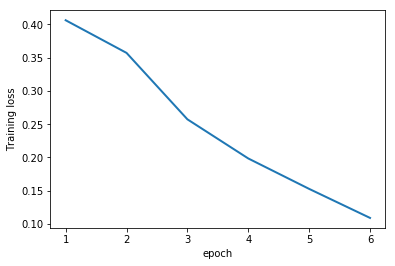

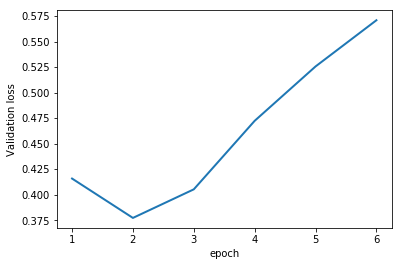

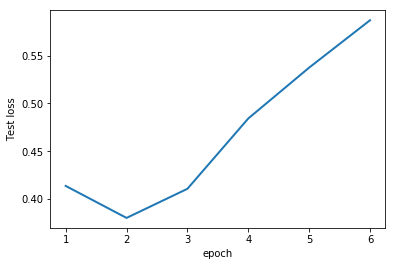

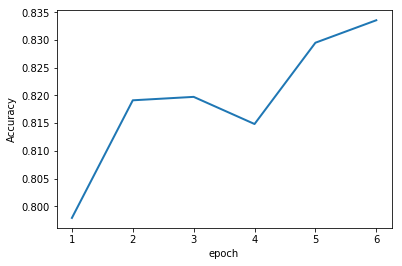

In [28]:
epochs = 6
# To print losses every now and then use the counter below
#counter = 0
#print_every = 2
clip = 5 # Gradient clipping

# If GPU is available, train on GPU
if (train_on_gpu):
    net.cuda()

net.train()
# Now our network is in training mode, lets train for some epochs
loss_vs_epoch = []
valloss_vs_epoch = []
testloss_vs_epoch = []
accuracy_vs_epoch = []
accuracy_old = 0.0
#accuracy_old_old =0.0
accuracy = 0.0
for e in range(0,epochs):
    # create hidden state
    h1 = net.init_hidden(batch_size)
    h2 = net.init_hidden(batch_size)
    # do this for every batch
    for inputs, labels in train_loader:
        #counter += 1
        if (train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        # Create new variables for the hidden state, so we don't backpropagate through entire training history
        h1 = tuple([each.data for each in h1])
        h2 = tuple([each.data for each in h2])
        # zero out the accumulated gradients
        net.zero_grad()
        output, h1, h2 = net(inputs, h1, h2)
        # Calculate loss and perform backpropagation
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # below we take care of exploding gradient problem
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        #print('finished training a batch')
        # Loss statistics
    loss_vs_epoch.append([e+1, loss.item()])
        #if counter % print_every == 0:
            # Calculate validation loss
    val_h1 = net.init_hidden(batch_size)
    val_h2 = net.init_hidden(batch_size)
    val_losses = []
    net.eval()
    for inputs, labels in valid_loader:
        val_h1 = tuple([each.data for each in val_h1])
        val_h2 = tuple([each.data for each in val_h2])
        if (train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        output, val_h1, val_h2 = net(inputs, val_h1, val_h2)
        val_loss = criterion(output.squeeze(), labels.float())                
        val_losses.append(val_loss.item())
    valloss_vs_epoch.append([e+1, np.mean(val_losses)])
    test_losses = []
    num_correct = 0
    test_h1 = net.init_hidden(batch_size)
    test_h2 = net.init_hidden(batch_size)    
    for inputs, labels in test_loader:
        test_h1 = tuple([each.data for each in test_h1])
        test_h2 = tuple([each.data for each in test_h2])
        if (train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        output, test_h1, test_h2 = net(inputs, test_h1, test_h2)
        test_loss = criterion(output.squeeze(), labels.float())                
        test_losses.append(test_loss.item())
        pred = torch.round(output.squeeze())
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)
    accuracy = num_correct/len(test_loader.dataset)
    if accuracy > accuracy_old:
        accuracy_old=accuracy
        model_name = 'best_model.net'
        checkpoint = {'vocab_size': net.vocab_size,
                     'output_size': net.output_size,
                     'embedding_dim': net.embedding_dim,
                     'hidden_dim': net.hidden_dim,
                     'n_layers':net.n_layers,
                     'state_dict': net.state_dict()}
        with open(model_name, 'wb') as f:
            torch.save(checkpoint, f)        
    testloss_vs_epoch.append([e+1, np.mean(test_losses)])
    accuracy_vs_epoch.append([e+1, num_correct/len(test_loader.dataset)])
    net.train()
    #print("Epoch: {}/{}---".format(e+1, epochs),
    #        "Step: {}---".format(counter),
    #        "Loss: {:.6f}---".format(loss.item()),
    #        "Val_Loss: {:.6f}".format(np.mean(val_losses)))
    print( "Epoch: {}/{}---finished---accuracy:{}".format(e+1,epochs, accuracy))

loss_vs_epoch = np.array(loss_vs_epoch)
valloss_vs_epoch = np.array(valloss_vs_epoch)
testloss_vs_epoch = np.array(testloss_vs_epoch)
accuracy_vs_epoch = np.array(accuracy_vs_epoch)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_vs_epoch[:,0], loss_vs_epoch[:,1], linewidth=2.0)
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.show()            

plt.plot(valloss_vs_epoch[:,0], valloss_vs_epoch[:,1], linewidth=2.0)
plt.xlabel('epoch')
plt.ylabel('Validation loss')
plt.show()            

plt.plot(testloss_vs_epoch[:,0], testloss_vs_epoch[:,1], linewidth=2.0)
plt.xlabel('epoch')
plt.ylabel('Test loss')
plt.show()            

plt.plot(accuracy_vs_epoch[:,0], accuracy_vs_epoch[:,1], linewidth=2.0)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()                    

In [ ]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -log(p)
    else:
        return -log(1-p)